#Predicting Stroke 
###With some past medical history and environmental factors we can predict if someone will have a stroke or not.  


###Install pip and needed libraries 

In [1]:
!pip install category_encoders==2.*
!pip install pandas-profiling==2.*
!pip install pdpbox
!pip install shap

     |████████████████████████████████| 80 kB 3.5 MB/s 
     |████████████████████████████████| 245 kB 4.2 MB/s 
     |████████████████████████████████| 76 kB 3.7 MB/s 
     |████████████████████████████████| 62 kB 880 kB/s 
     |████████████████████████████████| 102 kB 8.1 MB/s 
     |████████████████████████████████| 3.1 MB 7.8 MB/s 
     |████████████████████████████████| 675 kB 44.6 MB/s 
     |████████████████████████████████| 812 kB 45.0 MB/s 
     |████████████████████████████████| 28.5 MB 30 kB/s 
  Created wheel for htmlmin: filename=htmlmin-0.1.12-py3-none-any.whl size=27098 sha256=cf0bc4ede07dd5c5f3af88b94fe081d6ff061ba287e79fe2a20d50b83661e548
  Stored in directory: /root/.cache/pip/wheels/70/e1/52/5b14d250ba868768823940c3229e9950d201a26d0bd3ee8655
  Created wheel for imagehash: filename=ImageHash-4.2.1-py2.py3-none-any.whl size=295206 sha256=f5fa0cb610a44d2f387a0be5b9acaf7dba5223bfcba0fa5d81a91addcd1af008
  Stored in directory: /root/.cache/pip/wheels/4c/d5/59/5e3e297533d

     |████████████████████████████████| 356 kB 4.0 MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491651 sha256=48a214eaef62968f1728b05755c6ed82a4396dd77cde883b3893536fe5e6a0f0
  Stored in directory: /root/.cache/pip/wheels/ca/25/8f/6ae5df62c32651cd719e972e738a8aaa4a87414c4d2b14c9c0
Successfully built shap


In [2]:
# import libraries
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from category_encoders import OrdinalEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, plot_confusion_matrix, classification_report, recall_score, roc_auc_score, roc_curve, plot_roc_curve
from sklearn.model_selection import cross_val_score, validation_curve # k-fold CV
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV # Hyperparameter tuning
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.inspection import permutation_importance
from pandas_profiling import ProfileReport
from xgboost import XGBClassifier
import shap
from pdpbox.pdp import pdp_isolate, pdp_plot, pdp_interact, pdp_interact_plot

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Import and wrangle data 

You can download the data here:
https://www.kaggle.com/fedesoriano/stroke-prediction-dataset

In [4]:
# read in CSV w/ index col = 'id'
df = pd.read_csv('healthcare-dataset-stroke-data.csv', index_col='id')

# wrangle function
def wrangle(FILEPATH):

  # change married column from yes/no to 1/0 where 1=yes, 0=no
  df['ever_married'].replace("Yes", 1, inplace=True)
  df['ever_married'].replace("No", 0, inplace=True)


  return df

# call wrangle on the df 
df = wrangle(df)

The original data set had 249 people who had strokes and 4861 people who did not, making it very unbalanced.  I doubled the people who did have strokes, ending up with 498 and scaled down the people who did not have strokes by randomly choosing double the amount of the people who did, ending with 996 people who did not have strokes. 

In [5]:
# original df imbalanced stroke values (only 249 strokes: what we're prediciting)
print(df['stroke'].value_counts())
print('-----------------------------')

# MAKE DF TO END UP WITH 498 yes, 996 RANDOM NO'S

# df_yes = all yes (249)
df_yes = df.loc[df['stroke'] == 1]

# df_no = all no (4861)
df_no = df.loc[df['stroke'] == 0]

# check shapes
print('original shapes: ', df_yes.shape, df_no.shape)
print('-----------------------------')

# double yes's to equal 498 yes's
df_yes = df_yes.sample(498,replace=True, random_state=35)

# make sure df_yes ended up with 498 values 
print('df_yes value counts:', df_yes['stroke'].value_counts())
print('-----------------------------')

# check shape
print('df_yes shape:', df_yes.shape)
print('-----------------------------')

# randomly pick double amount of yes's for no df
df_no = df_no.sample(996, replace=False, random_state=35)

# make sure df_no ended up with 996 values
print('df_no value counts:', df_no['stroke'].value_counts())
print('-----------------------------')

# check shape
print('df_no shape:', df_no.shape)
print('-----------------------------')

# concat yes and no df together and replace over old df
df = pd.concat([df_yes, df_no])

# print values to make sure ended up w/ 996 0's and 498 1's
print('New df STROKE value counts:', df['stroke'].value_counts())

0    4861
1     249
Name: stroke, dtype: int64
-----------------------------
original shapes:  (249, 11) (4861, 11)
-----------------------------
df_yes value counts: 1    498
Name: stroke, dtype: int64
-----------------------------
df_yes shape: (498, 11)
-----------------------------
df_no value counts: 0    996
Name: stroke, dtype: int64
-----------------------------
df_no shape: (996, 11)
-----------------------------
New df STROKE value counts: 0    996
1    498
Name: stroke, dtype: int64


###Exploratory Data Analysis 

In [6]:
# Run profile report to assess data
Report = ProfileReport(df, minimal=True).to_notebook_iframe()

Report

Summarize dataset:   0%|          | 0/20 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

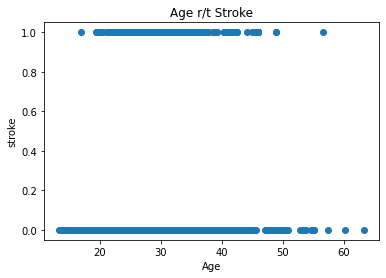

In [7]:
# matplotlib scatter plot
plt.scatter(data=df, x='bmi', y='stroke')
plt.xlabel('Age')
plt.ylabel('stroke')
plt.title('Age r/t Stroke')

plt.show()

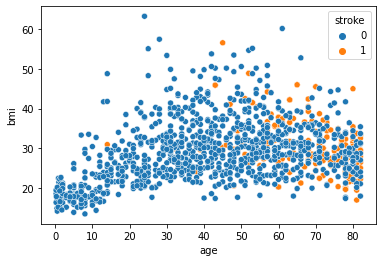

In [8]:
# seaborn scatterplot
sns.scatterplot(data=df, x='age', y='bmi', hue='stroke');


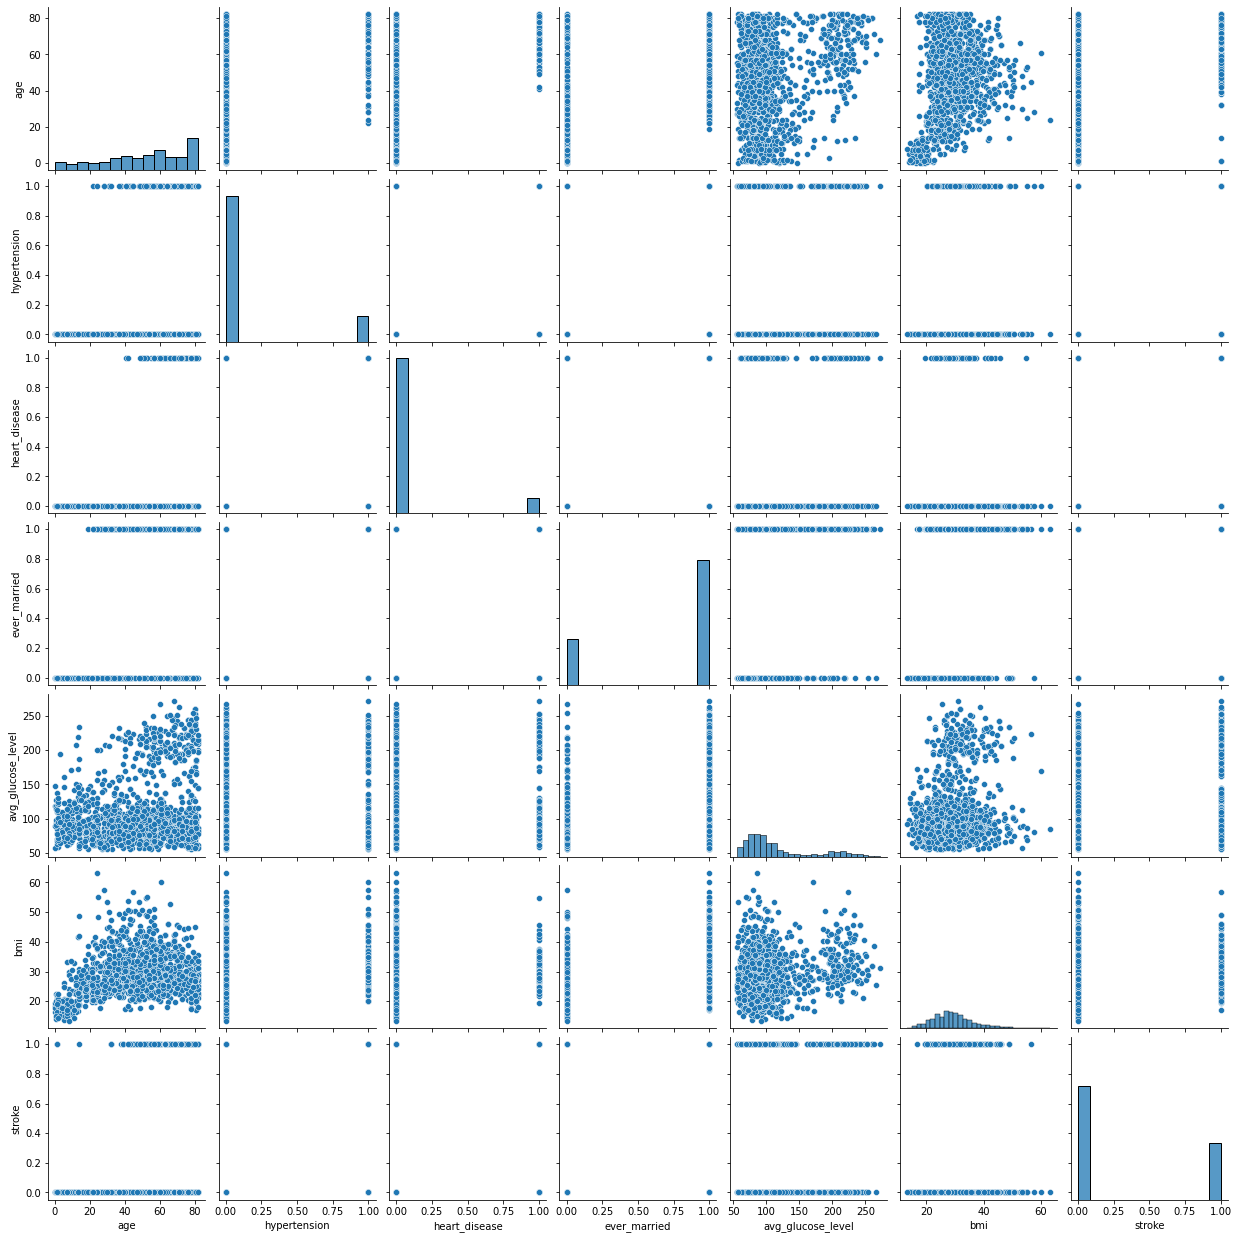

In [9]:
# seaborn pairplot to look at relationships of all features 
sns.pairplot(data=df);

In [10]:
df.info()
# BMI missing data (fill with Simple Imputer)

# CATEGORICAL/OBJECT COLUMNS 
# work_type has 5 categorical columns (private/self-employed/children/govt_job/never_worked)
# residence_type has 2 categorical columns (rural/urban)
# smoking_status has 4 categorical columns (never/unknown/former/smokes)
# gender has 2 categorical columns (male/female)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1494 entries, 68627 to 56547
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             1494 non-null   object 
 1   age                1494 non-null   float64
 2   hypertension       1494 non-null   int64  
 3   heart_disease      1494 non-null   int64  
 4   ever_married       1494 non-null   int64  
 5   work_type          1494 non-null   object 
 6   Residence_type     1494 non-null   object 
 7   avg_glucose_level  1494 non-null   float64
 8   bmi                1384 non-null   float64
 9   smoking_status     1494 non-null   object 
 10  stroke             1494 non-null   int64  
dtypes: float64(3), int64(4), object(4)
memory usage: 140.1+ KB


### Baseline Accuracy for predicting stroke = 66%

In [11]:
# Baseline Accuracy for predicitng stoke (1)
df['stroke'].value_counts(normalize=True).max()
# 66% didn't have stroke
# 33% DID have stroke

0.6666666666666666

### Splitting Data 

In [12]:
# assign target as stroke column (what we're predicitng)
target = 'stroke'

# assign target column to y vector
y = df[target]

# assign all other columns to X matrix 
X = df.drop(columns=target)

print(X.shape)
print(y.shape)

(1494, 10)
(1494,)


Data split into 90/10 (for cross validation model)

In [13]:
# data split for cross validation ONLY (90% training, 10% for testing)
X_CVtrain, X_CVtest, y_CVtrain, y_CVtest = train_test_split(X, y, test_size=0.1, random_state=42)

print(X_CVtrain.shape)
print(y_CVtrain.shape)
print(X_CVtest.shape)
print(y_CVtest.shape)

(1344, 10)
(1344,)
(150, 10)
(150,)


Data split into 80/20 for XGBoost model and final testing 

In [14]:
# data split for XGboost and final testing (80% training, 20% for testing)
X_xgtrain, X_xgtest, y_xgtrain, y_xgtest = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_xgtrain.shape)
print(y_xgtrain.shape)
print(X_xgtest.shape)
print(y_xgtest.shape)

(1195, 10)
(1195,)
(299, 10)
(299,)


Data split into 60/20/20 

In [15]:
# # split data into 60% of total for training, 40% of total for val/testing
X_train, X_val2, y_train, y_val2 = train_test_split(X, y, test_size=0.4, random_state=42)


# # split that 40% for val/testing into 50% val and 50% testing 
X_val, X_test, y_val, y_test = train_test_split(X_val2, y_val2, test_size=0.5, random_state=42)

print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)
print(X_train.shape)
print(y_train.shape)

(299, 10)
(299,)
(299, 10)
(299,)
(896, 10)
(896,)


### Cross Validation Model using Logistical Regression with RandomizedSearch

In [16]:
# make basic LR model to use for CV 
model_basiclr = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    StandardScaler(),
    LogisticRegression(random_state=42))

In [17]:
# find CV scores for model
cv_scores = cross_val_score(model_basiclr, X_CVtrain, y_CVtrain, cv=5, n_jobs=-1)
cv_scores

array([0.79182156, 0.79553903, 0.72862454, 0.79925651, 0.82089552])

In [18]:
# metrics for Random Forest model CV scores
print('CV score RandomForestClassifier')
print(cv_scores)
print('Mean CV accuracy score:', cv_scores.mean())
print('STD CV accuracy score:', cv_scores.std())

CV score RandomForestClassifier
[0.79182156 0.79553903 0.72862454 0.79925651 0.82089552]
Mean CV accuracy score: 0.7872274316151584
STD CV accuracy score: 0.030992667405045315


Logistical Regression Parameter tuning using RandomizedSearchCV




In [19]:
# make parameters grid for testing for Randomized Search for LR 
param_grid = {
    'simpleimputer__strategy':['mean','median'],
    'logisticregression__max_iter': range(25,200,25),
}

# make Randomized Search CV model using basic logistical regression model (model_basiclr)
model_randomCV_LR = RandomizedSearchCV(
    model_basiclr,
    param_distributions = param_grid,
    cv = 5,
    n_jobs = -1,
    verbose = 1)

# train on 90% of the data 
model_randomCV_LR.fit(X_CVtrain,y_CVtrain)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.8s finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('ordinalencoder',
                                              OrdinalEncoder(cols=None,
                                                             drop_invariant=False,
                                                             handle_missing='value',
                                                             handle_unknown='value',
                                                             mapping=None,
                                                             return_df=True,
                                                             verbose=0)),
                                             ('simpleimputer',
                                              SimpleImputer(add_indicator=False,
                                                            copy=True,
                                                            fill_value=None,


In [20]:
# best LR scores/params with CV model 
best_score = model_randomCV_LR.best_score_
best_params = model_randomCV_LR.best_params_

print('Best accuracy score for model:', best_score)
print('Best params for model:', best_params)

# best params:
# SimpleImputer = mean
# max_iter = 75

Best accuracy score for model: 0.7872274316151584
Best params for model: {'simpleimputer__strategy': 'mean', 'logisticregression__max_iter': 75}


New LR model using best parameters found from tuning 

In [21]:
# use best params to make NEW LR model
model_lr_fromrandCV = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(strategy='mean'),
    StandardScaler(),
    LogisticRegression(random_state=42, n_jobs=-1, max_iter=75)
)

# fit with 80/20 data instead of 90/10
model_lr_fromrandCV.fit(X_xgtrain, y_xgtrain)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['gender', 'work_type', 'Residence_type',
                                      'smoking_status'],
                                drop_invariant=False, handle_missing='value',
                                handle_unknown='value',
                                mapping=[{'col': 'gender',
                                          'data_type': dtype('O'),
                                          'mapping': Female    1
Male      2
NaN      -2
dtype: int64},
                                         {'col': 'work_type',
                                          'data_type': dtype('O'),
                                          'mapping': Private          1
Self-employe...
                               verbose=0)),
                ('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('logisticregression',
                 LogisticRegress

###Logistic Regression Metrics 
- LR Training accuracy: 79%
- LR Testing accuracy: 79%
- Precision: 70%
- Recall: 63%

In [22]:
# Training and testing accuracy scores for NEW LR model using 80/20 data 
print('LR Training accuracy score:', model_lr_fromrandCV.score(X_xgtrain, y_xgtrain))
print('LR Testing accuracy score:', model_lr_fromrandCV.score(X_xgtest, y_xgtest))

LR Training accuracy score: 0.7882845188284519
LR Testing accuracy score: 0.7859531772575251


In [23]:
# classification report shows 70% precision, 63% recall
print(classification_report(y_xgtest, model_lr_fromrandCV.predict(X_xgtest), target_names=['0 = No Stroke', '1 = Stroke']))

               precision    recall  f1-score   support

0 = No Stroke       0.82      0.86      0.84       200
   1 = Stroke       0.70      0.63      0.66        99

     accuracy                           0.79       299
    macro avg       0.76      0.75      0.75       299
 weighted avg       0.78      0.79      0.78       299



### Cross Validation Model using Random Forests with RandomizedSearch


In [24]:
# make basic Random Forest model (DONT FIT ANYTHING TO IT) to use for Cross Validation
model_basicrf = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    RandomForestClassifier(random_state=42))

In [25]:
# find CV scores for model
cv_scores = cross_val_score(model_basicrf, X_CVtrain, y_CVtrain, cv=5, n_jobs=-1)
cv_scores

array([0.87360595, 0.89591078, 0.866171  , 0.87360595, 0.86940299])

In [26]:
# metrics for Random Forest model CV scores
print('CV score RandomForestClassifier')
print(cv_scores)
print('Mean CV accuracy score:', cv_scores.mean())
print('STD CV accuracy score:', cv_scores.std())

CV score RandomForestClassifier
[0.87360595 0.89591078 0.866171   0.87360595 0.86940299]
Mean CV accuracy score: 0.875739333074405
STD CV accuracy score: 0.01046606129216185


Random Forest Parameter tuning using RandomizedSearchCV


In [27]:
# make parameters grid for testing for Randomized Search for RF
param_grid = {
    'simpleimputer__strategy':['mean','median'],
    'randomforestclassifier__max_depth': range(5,35,5),
    'randomforestclassifier__n_estimators': range(25,125,25)
}

# make Randomized Search CV model using basic random forest model (model_basicrf)
model_randomCV = RandomizedSearchCV(
    model_basicrf,
    param_distributions = param_grid,
    n_iter = 25,
    cv = 5,
    n_jobs = -1,
    verbose = 1)

# train on 90% of the data 
model_randomCV.fit(X_CVtrain,y_CVtrain)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed:   17.6s finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('ordinalencoder',
                                              OrdinalEncoder(cols=None,
                                                             drop_invariant=False,
                                                             handle_missing='value',
                                                             handle_unknown='value',
                                                             mapping=None,
                                                             return_df=True,
                                                             verbose=0)),
                                             ('simpleimputer',
                                              SimpleImputer(add_indicator=False,
                                                            copy=True,
                                                            fill_value=None,


In [29]:
# best scores/params with CV model 
best_score = model_randomCV.best_score_
best_params = model_randomCV.best_params_

print('Best accuracy score for model:', best_score)
print('Best params for model:', best_params)

# best params:
# SimpleImputer = median
# n_estimator = 75
# max_depth = 25

Best accuracy score for model: 0.877223547689064
Best params for model: {'simpleimputer__strategy': 'median', 'randomforestclassifier__n_estimators': 75, 'randomforestclassifier__max_depth': 25}


New RF model using best parameters found from tuning

In [30]:
# use best params to make NEW RF model
model_rf_fromrandCV = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(strategy='median'),
    RandomForestClassifier(random_state=42, n_jobs=-1, n_estimators=75, max_depth=25)
)

# fit with 80/20 data instead of 90/10
model_rf_fromrandCV.fit(X_xgtrain, y_xgtrain)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['gender', 'work_type', 'Residence_type',
                                      'smoking_status'],
                                drop_invariant=False, handle_missing='value',
                                handle_unknown='value',
                                mapping=[{'col': 'gender',
                                          'data_type': dtype('O'),
                                          'mapping': Female    1
Male      2
NaN      -2
dtype: int64},
                                         {'col': 'work_type',
                                          'data_type': dtype('O'),
                                          'mapping': Private          1
Self-employe...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=25, max_features='auto',
   

###Random Forest Metrics
- RF Training accuracy: 100%
- RF Testing accuracy: 87%
- Precision: 81%
- Recall: 81%
- THIS IS THE BEST MODEL

In [31]:
# Training and testing accuracy scores for NEW RF model using 80/20 data 
print('RF Training accuracy score:', model_rf_fromrandCV.score(X_xgtrain, y_xgtrain))
print('RF Testing accuracy score:', model_rf_fromrandCV.score(X_xgtest, y_xgtest))

RF Training accuracy score: 1.0
RF Testing accuracy score: 0.8729096989966555


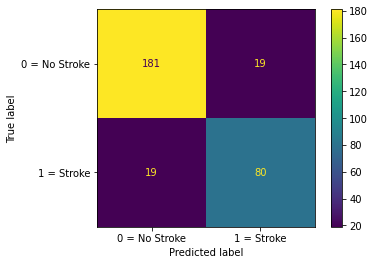

In [32]:
# plot new confusion matrix with NEW RF model using 80/20 data 
plot_confusion_matrix(model_rf_fromrandCV, X_xgtest, y_xgtest, values_format = '.0f', display_labels=['0 = No Stroke', '1 = Stroke']);

In [34]:
# classification report shows 81% precision, 81% recall
print(classification_report(y_xgtest, model_rf_fromrandCV.predict(X_xgtest), target_names=['0 = No Stroke', '1 = Stroke']))


               precision    recall  f1-score   support

0 = No Stroke       0.91      0.91      0.91       200
   1 = Stroke       0.81      0.81      0.81        99

     accuracy                           0.87       299
    macro avg       0.86      0.86      0.86       299
 weighted avg       0.87      0.87      0.87       299



### Graphing Results


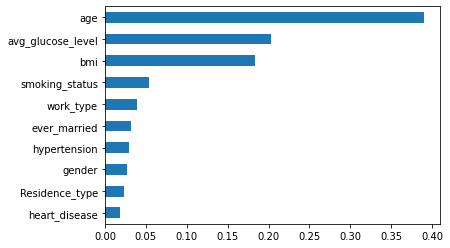

In [35]:
# importance features of BEST model (model_rf_fromrandCV)
importances = model_rf_fromrandCV.named_steps['randomforestclassifier'].feature_importances_
feature_names = X_xgtrain.columns
feat_imp = pd.Series(data=importances, index=feature_names).sort_values()
feat_imp.tail(10).plot(kind='barh');

In [36]:
# get models permutation importances of model_rf_fromrandCV 
perm_imp = permutation_importance(model_rf_fromrandCV , X_xgtest, y_xgtest, random_state=42)


In [37]:
# an array of permutation importances for model_rf_fromrandCV 
perm_imp

{'importances': array([[ 0.02006689,  0.00668896,  0.00668896,  0.01337793,  0.01337793],
        [ 0.19063545,  0.21070234,  0.22073579,  0.23411371,  0.2173913 ],
        [ 0.02006689,  0.01003344,  0.01672241,  0.01003344,  0.00668896],
        [ 0.01672241,  0.01003344,  0.00668896,  0.01003344,  0.01003344],
        [ 0.00334448,  0.01003344,  0.01003344,  0.        ,  0.00668896],
        [-0.01337793, -0.02006689,  0.00334448,  0.        , -0.00334448],
        [ 0.00334448,  0.00668896,  0.01672241,  0.00334448,  0.01337793],
        [ 0.05016722,  0.05685619,  0.07023411,  0.0735786 ,  0.07692308],
        [ 0.06688963,  0.03344482,  0.06020067,  0.04013378,  0.04682274],
        [ 0.03010033,  0.04013378,  0.02006689,  0.01003344,  0.03010033]]),
 'importances_mean': array([ 0.01204013,  0.21471572,  0.01270903,  0.01070234,  0.00602007,
        -0.00668896,  0.00869565,  0.06555184,  0.04949833,  0.02608696]),
 'importances_std': array([0.00500556, 0.01425236, 0.00491536, 0.

In [38]:
# make df out of permutation importances array for model_rf_fromrandCV 
data = {'imp_mean':perm_imp['importances_mean'],
        'imp_std':perm_imp['importances_std']}
df_perm = pd.DataFrame(data,index=X_xgtest.columns).sort_values(by='imp_mean')

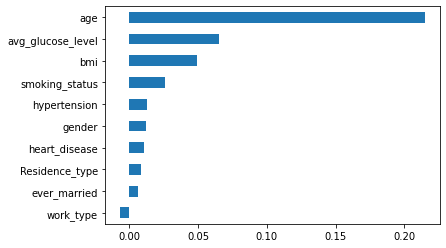

In [39]:
# plot permutation importances for model_rf_fromrandCV 
df_perm['imp_mean'].tail(10).plot(kind='barh');

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


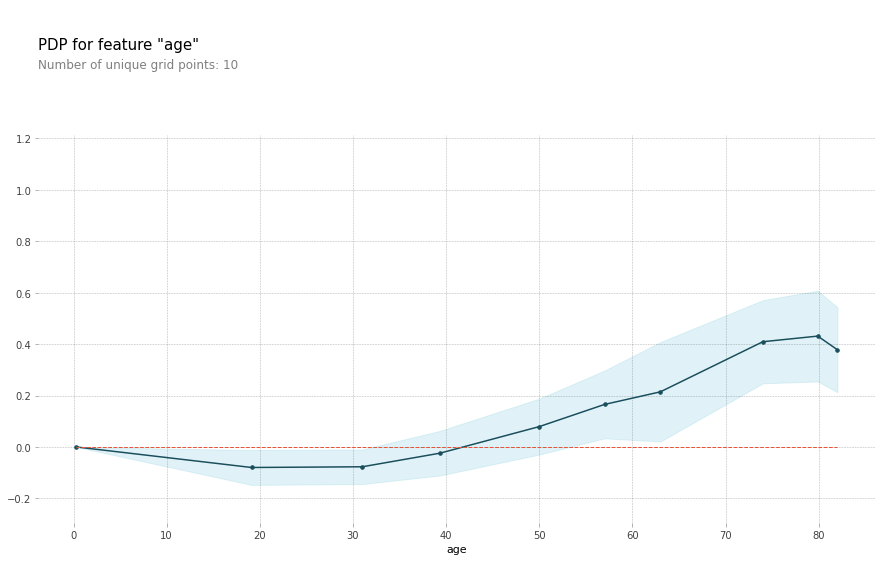

In [40]:
# Partial Dependence plot with ONE FEATURE 
isolate = pdp_isolate(model_rf_fromrandCV,
                      dataset = X_xgtest,
                      model_features = X_xgtest.columns,
                      feature = 'age')

pdp_plot(isolate, feature_name = 'age');

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


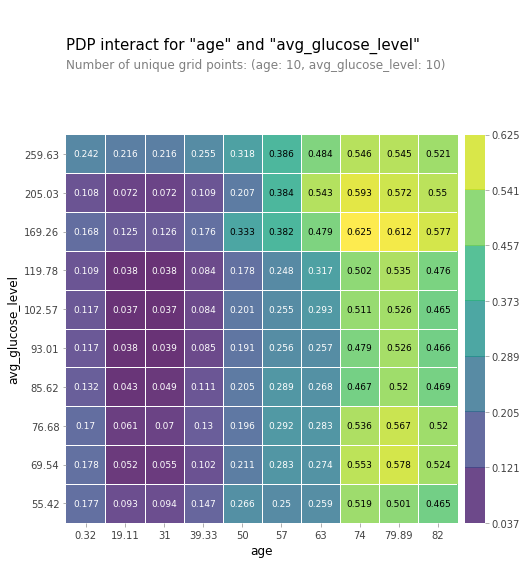

In [41]:
# Partial Dependence plot with TWO FEATURES
features = ['age', 'avg_glucose_level']
interact = pdp_interact(model_rf_fromrandCV,
                        dataset = X_xgtest,
                        model_features = X_xgtest.columns,
                        features = features)

pdp_interact_plot(interact, plot_type='grid', feature_names=features);

In [42]:
# SHAPLEY PLOT 

# make transform pipeline using OrdinalEncoder and Simple Imputer 
transformer = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(strategy='median'))

# transform training and testing data 
trans_X_train = transformer.fit_transform(X_xgtrain, y_xgtrain)
trans_X_test = transformer.fit_transform(X_xgtest, y_xgtest)

# put transformed data through RF classifier called shapley_model 
shapley_model = RandomForestClassifier(random_state=42, n_jobs=-1, n_estimators=75, max_depth=25)
shapley_model.fit(trans_X_train, y_xgtrain)

# this is all doing the same thing as our previous pipeline, but you can't use a pipeline for the Shapley Plot

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=25, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=75, n_jobs=-1,
                       oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [43]:
# turn transformed data into a df to be able to use it in Shapley plot
trans_X_testDF = pd.DataFrame(trans_X_test)
trans_X_testDF

,0,1,2,3,4,5,6,7,8,9
0,2.0,50.0,0.0,1.0,0.0,1.0,2.0,85.82,31.9,4.0
1,1.0,27.0,0.0,0.0,0.0,1.0,1.0,75.04,24.5,4.0
2,1.0,39.0,0.0,0.0,1.0,1.0,1.0,89.32,31.0,3.0
3,2.0,47.0,0.0,0.0,1.0,1.0,1.0,110.38,30.1,2.0
4,1.0,5.0,0.0,0.0,0.0,3.0,2.0,122.25,16.7,2.0
...,...,...,...,...,...,...,...,...,...,...
294,1.0,66.0,0.0,0.0,1.0,4.0,1.0,85.52,30.0,4.0
295,1.0,60.0,0.0,0.0,1.0,1.0,1.0,230.78,40.2,4.0
296,1.0,49.0,0.0,0.0,1.0,4.0,2.0,68.68,28.8,4.0
297,1.0,35.0,0.0,0.0,0.0,1.0,2.0,71.59,40.3,4.0


In [44]:
# FORCED SHAPLEY PLOT showing influence of features on individual prediction

# assign sample from X_xgtest set 
samp = trans_X_testDF.head(1)
samp

,0,1,2,3,4,5,6,7,8,9
0,2.0,50.0,0.0,1.0,0.0,1.0,2.0,85.82,31.9,4.0


In [45]:
# make Shapley Plot 
explainer = shap.TreeExplainer(shapley_model)
shap_values = explainer.shap_values(samp)
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0],
                 features = samp)

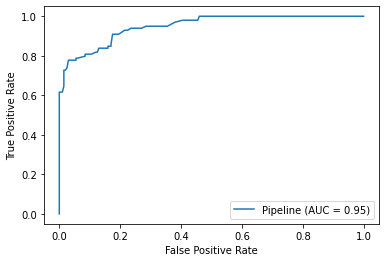

In [46]:
# ROC for rf model using testing data 
rf = plot_roc_curve(model_rf_fromrandCV, X_xgtest, y_xgtest)